# MadMiner particle physics tutorial

# Part 2b: Analyzing events at Delphes level

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In this second part of the tutorial, we'll generate events and extract the observables and weights from them. You have two options: In this notebook we'll do this with Delphes, in the alternative part 2a we stick to parton level.

## 0. Preparations

Before you execute this notebook, make sure you have working installations of MadGraph, Pythia, and Delphes.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


from madminer.core import MadMiner
from madminer.delphes import DelphesReader
from madminer.sampling import combine_and_shuffle
from madminer.plotting import plot_distributions


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5.

In [3]:
mg_dir = '/home/llr/cms/cortinovis/EFT2Obs/MG5_aMC_v2_6_7'

## 1. Generate events

Let's load our setup:

In [37]:
miner = MadMiner()
miner.load("/data_CMS/cms/cortinovis/hel/data_hel_w_b/setup.h5")

20:42 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.
20:42 madminer.core.madmin INFO    Found 2 parameters:
20:42 madminer.core.madmin INFO       cWW (LHA: newcoup 7, maximal power in squared ME: (2,), range: (-10.0, 10.0))
20:42 madminer.core.madmin INFO       cB (LHA: newcoup 8, maximal power in squared ME: (2,), range: (-10.0, 10.0))
20:42 madminer.core.madmin INFO    Found 6 benchmarks:
20:42 madminer.core.madmin INFO       sm: cWW = 0.00e+00, cB = 0.00e+00
20:42 madminer.core.madmin INFO       w: cWW = 6.00, cB = 0.10
20:42 madminer.core.madmin INFO       neg_w: cWW = -6.80e+00, cB = 0.20
20:42 madminer.core.madmin INFO       ww: cWW = 0.40, cB = 6.60
20:42 madminer.core.madmin INFO       neg_ww: cWW = 0.30, cB = -6.70e+00
20:42 madminer.core.madmin INFO       morphing_basis_vector_5: cWW = -9.38e+00, cB = 6.84
20:42 madminer.core.madmin INFO    Found morphing setup with 6 components
20:42 madminer.core.madmin INFO    Did not find systematics setup.


In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You can use `run()` or `run_multiple()`; the latter allows to generate different runs with different run cards and optimizing the phase space for different benchmark points. 

In either case, you have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card. Log files in the `log_directory` folder collect the MadGraph output and are important for debugging.

The `sample_benchmark` (or in the case of `run_all`, `sample_benchmarks`) option can be used to specify which benchmark should be used for sampling, i.e. for which benchmark point the phase space is optimized. If you just use one benchmark, reweighting to far-away points in parameter space can lead to large event weights and thus large statistical fluctuations. It is therefore often a good idea to combine at least a few different benchmarks for this option. Here we use the SM and the benchmark "w" that we defined during the setup step.

One slight annoyance is that MadGraph only supports Python 2. The `run()` and `run_multiple()` commands have a keyword `initial_command` that let you load a virtual environment in which `python` maps to Python 2 (which is what we do below). Alternatively / additionally you can set `python2_override=True`, which calls `python2.7` instead of `python` to start MadGraph.

In [38]:
additional_benchmarks = ['w', 'ww', 'neg_w', 'neg_ww']


In [39]:
miner.run_multiple(
    sample_benchmarks=additional_benchmarks,
    mg_directory=mg_dir,
    temp_directory = './',
    mg_process_directory='./mg_processes_hel_test/signal_pythia2',
    proc_card_file='cards/proc_card_signal_hel_vbf.dat',
    param_card_template_file='cards/param_card_template_hel.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    run_card_files=['cards/run_card_hel_small.dat'],
    log_directory='logs_hel_test/signal2',
    initial_command="PYTHONPATH=/usr/lib64/python",
    python2_override=True,
)

20:42 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal_hel_vbf.dat at ./mg_processes_hel_test/signal_pythia2
20:43 madminer.core.madmin INFO    Run 0
20:43 madminer.core.madmin INFO      Sampling from benchmark: w
20:43 madminer.core.madmin INFO      Original run card:       cards/run_card_hel_small.dat
20:43 madminer.core.madmin INFO      Original Pythia8 card:   cards/pythia8_card.dat
20:43 madminer.core.madmin INFO      Original config card:    None
20:43 madminer.core.madmin INFO      Copied run card:         /madminer/cards/run_card_0.dat
20:43 madminer.core.madmin INFO      Copied Pythia8 card:     /madminer/cards/pythia8_card_0.dat
20:43 madminer.core.madmin INFO      Copied config card:      None
20:43 madminer.core.madmin INFO      Param card:              /madminer/cards/param_card_0.dat
20:43 madminer.core.madmin INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
20:43 madminer.core.madmin INFO      Log file:    

KeyboardInterrupt: 

In [429]:
miner.run(
    sample_benchmark='sm',
    temp_directory = './',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes_hel_h_hw/signal_pythia',
    proc_card_file='cards/proc_card_signal_hel_vbf.dat',
    param_card_template_file='cards/param_card_template_hel.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    run_card_file='cards/run_card_hel_large.dat',
    log_directory='logs_hel_h_hw/signal',
    initial_command="PYTHONPATH=/usr/lib64/python",
    python2_override=True,
)

20:51 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal_hel_vbf.dat at ./mg_processes_hel_h_hw/signal_pythia
20:51 madminer.core.madmin INFO    Run 0
20:51 madminer.core.madmin INFO      Sampling from benchmark: sm
20:51 madminer.core.madmin INFO      Original run card:       cards/run_card_hel_large.dat
20:51 madminer.core.madmin INFO      Original Pythia8 card:   cards/pythia8_card.dat
20:51 madminer.core.madmin INFO      Original config card:    None
20:51 madminer.core.madmin INFO      Copied run card:         /madminer/cards/run_card_0.dat
20:51 madminer.core.madmin INFO      Copied Pythia8 card:     /madminer/cards/pythia8_card_0.dat
20:51 madminer.core.madmin INFO      Copied config card:      None
20:51 madminer.core.madmin INFO      Param card:              /madminer/cards/param_card_0.dat
20:51 madminer.core.madmin INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
20:51 madminer.core.madmin INFO      Log file:    

KeyboardInterrupt: 

This will take a moment -- time for a coffee break!

After running any event generation through MadMiner, you should check whether the run succeeded: are the usual output files there (LHE and HepMC), do the log files show any error messages? MadMiner does not (yet) perform any explicit checks, and if something went wrong in the event generation, it will only notice later when trying to load the event files.

### Backgrounds

We can also easily add other processes like backgrounds. An important option is the `is_background` keyword, which should be used for processes that do *not* depend on the parameters theta. `is_background=True` will disable the reweighting and re-use the same weights for all cross sections.

To reduce the runtime of the notebook, the background part is commented out here. Feel free to activate it and let it run during a lunch break.

In [145]:
"""
miner.run(
    is_background=True,
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/background_pythia',
    proc_card_file='cards/proc_card_background.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_background.dat',
    log_directory='logs/background',
)
"""

"\nminer.run(\n    is_background=True,\n    sample_benchmark='sm',\n    mg_directory=mg_dir,\n    mg_process_directory='./mg_processes/background_pythia',\n    proc_card_file='cards/proc_card_background.dat',\n    pythia8_card_file='cards/pythia8_card.dat',\n    param_card_template_file='cards/param_card_template.dat',\n    run_card_file='cards/run_card_background.dat',\n    log_directory='logs/background',\n)\n"

Finally, note that both `MadMiner.run()` and `MadMiner.run_multiple()` have a `only_create_script` keyword. If that is set to True, MadMiner will not start the event generation directly, but prepare folders with all the right settings and ready-to-run bash scripts. This might make it much easier to generate Events on a high-performance computing system. 

## 2. Run Delphes

The `madminer.delphes.DelphesReader` class wraps around Delphes, a popular fast detector simulation, to simulate the effects of the detector.

In [5]:
delphes = DelphesReader('/data_CMS/cms/cortinovis/ewdim6/data_ew_1M/setup.h5')

15:53 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.


After creating the `DelphesReader` object, one can add a number of event samples (the output of running MadGraph and Pythia in step 1 above) with the `add_sample()` function.

In addition, you have to provide the information which sample was generated from which benchmark with the `sampled_from_benchmark` keyword, and set `is_background=True` for all background samples.

In [445]:
delphes.add_sample(
    lhe_filename='/data_CMS/cms/cortinovis/ewdim6/mg_processes_ew_1M/signal_pythia/Events/run_01/unweighted_events.lhe.gz',
    hepmc_filename='/data_CMS/cms/cortinovis/ewdim6/mg_processes_ew_1M/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm',
    is_background=False,
    k_factor=1, #Why??
)

additional_benchmarks = ['w', 'neg_w', 'ww', 'neg_ww']

for i, benchmark in enumerate(additional_benchmarks):
    delphes.add_sample(
        lhe_filename='/data_CMS/cms/cortinovis/ewdim6/mg_processes_ew_1M/signal_pythia2/Events/run_0{}/unweighted_events.lhe.gz'.format(i+1),
        hepmc_filename='/data_CMS/cms/cortinovis/ewdim6/mg_processes_ew_1M/signal_pythia2/Events/run_0{}/tag_1_pythia8_events.hepmc.gz'.format(i+1),
        sampled_from_benchmark=benchmark,
        is_background=False,
        k_factor=1,
    )

"""
delphes.add_sample(
    lhe_filename='mg_processes/background_pythia/Events/run_01/unweighted_events.lhe.gz',
    hepmc_filename='mg_processes/background_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm',
    is_background=True,
    k_factor=1.0,
"""


17:18 madminer.delphes.del DEBUG   Adding event sample mg_processes_hel/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz
17:18 madminer.delphes.del DEBUG   Adding event sample mg_processes_hel/signal_pythia2/Events/run_01/tag_1_pythia8_events.hepmc.gz
17:18 madminer.delphes.del DEBUG   Adding event sample mg_processes_hel/signal_pythia2/Events/run_02/tag_1_pythia8_events.hepmc.gz
17:18 madminer.delphes.del DEBUG   Adding event sample mg_processes_hel/signal_pythia2/Events/run_03/tag_1_pythia8_events.hepmc.gz
17:18 madminer.delphes.del DEBUG   Adding event sample mg_processes_hel/signal_pythia2/Events/run_04/tag_1_pythia8_events.hepmc.gz


"\ndelphes.add_sample(\n    lhe_filename='mg_processes/background_pythia/Events/run_01/unweighted_events.lhe.gz',\n    hepmc_filename='mg_processes/background_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',\n    sampled_from_benchmark='sm',\n    is_background=True,\n    k_factor=1.0,\n"

Now we run Delphes on these samples (you can also do this externally and then add the keyword `delphes_filename` when calling `DelphesReader.add_sample()`):

In [446]:
delphes.run_delphes(
    delphes_directory=mg_dir + '/HEPTools/Delphes-3.4.2',
    delphes_card='cards/delphes_card_CMS.dat',
    log_file='/data_CMS/cms/cortinovis/ewdim6/logs_ew_1M/delphes_mjj.log',
)

17:18 madminer.delphes.del INFO    Running Delphes on HepMC sample at mg_processes_hel/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz
17:18 madminer.utils.inter DEBUG   Unzipping mg_processes_hel/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz
17:43 madminer.utils.inter DEBUG   Deleting mg_processes_hel/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc
17:43 madminer.delphes.del INFO    Running Delphes on HepMC sample at mg_processes_hel/signal_pythia2/Events/run_01/tag_1_pythia8_events.hepmc.gz
17:43 madminer.utils.inter DEBUG   Unzipping mg_processes_hel/signal_pythia2/Events/run_01/tag_1_pythia8_events.hepmc.gz
17:48 madminer.utils.inter DEBUG   Deleting mg_processes_hel/signal_pythia2/Events/run_01/tag_1_pythia8_events.hepmc
17:48 madminer.delphes.del INFO    Running Delphes on HepMC sample at mg_processes_hel/signal_pythia2/Events/run_02/tag_1_pythia8_events.hepmc.gz
17:48 madminer.utils.inter DEBUG   Unzipping mg_processes_hel/signal_pythia2/Events/run_0

## 3. Observables and cuts

The next step is the definition of observables, either through a Python function or an expression that can be evaluated. Here we demonstrate the latter, which is implemented in `add_observable()`. In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

All of these represent objects inheriting from scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties. In addition, they have `charge` and `pdg_id` properties.

`add_observable()` has an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with the value of another keyword `default`.

In a realistic project, you would want to add a large number of observables that capture all information in your events. Here we will just define two observables, the transverse momentum of the leading (= higher-pT) jet, and the azimuthal angle between the two leading jets.

In [447]:
delphes.add_observable(
    'pt_j1',
    'j[0].pt',
    required=False,
    default=float('nan'),
    #default=0,
)


delphes.add_observable(
    'delta_phi_jj',
    'j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))',
    required=False,
    default=float('nan'),
    #default=0,
)

delphes.add_observable(
    'delta_eta_jj',
    'j[0].deltaeta(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))',
    required=False,
    default=float('nan'),
    #default=0,
)

delphes.add_observable(
    'eta_j1',
    'j[0].eta',
    required=False,
    default=float('nan'),
    #default=0,
)

delphes.add_observable(
    'eta_j2',
    'j[1].eta',
    required=False,
    default=float('nan'),
    #default=0,
)


delphes.add_observable(
    'm_jj',
    '(j[0]+j[1]).m',
    required=False,
    default=float('nan'),
    #default=0,
)

delphes.add_observable(
    'isZZcand',
    'isZZcand',
    required=True,
)

delphes.add_observable(
    'H_pt',
    '(lep1ZZ+lep2ZZ+lep3ZZ+lep4ZZ).pt',
    required=True,
)

delphes.add_observable(
    'H_m',
    '(lep1ZZ+lep2ZZ+lep3ZZ+lep4ZZ).m',
    required=True,
)

delphes.add_observable(
    'H_eta',
    '(lep1ZZ+lep2ZZ+lep3ZZ+lep4ZZ).eta',
    required=True,
)

delphes.add_observable(
    'Z1_pt',
    '(lep1ZZ+lep2ZZ).pt',
    required=True,
)

delphes.add_observable(
    'Z2_pt',
    '(lep3ZZ+lep4ZZ).pt',
    required=True,
)

delphes.add_observable(
    'Z2_m',
    '(lep3ZZ+lep4ZZ).m',
    required=True,
)

delphes.add_observable(
    'Z1_eta',
    '(lep1ZZ+lep2ZZ).eta',
    required=True,
)

delphes.add_observable(
    'Z2_eta',
    '(lep3ZZ+lep4ZZ).eta',
    required=True,
)

delphes.add_observable(
    'delta_phi_zz',
    '(lep1ZZ+lep2ZZ).deltaphi(lep3ZZ+lep4ZZ) * (-1. + 2.*float((lep1ZZ+lep2ZZ).eta > (lep3ZZ+lep4ZZ).eta))',
    required=False,
    default=float('nan'),
    #default=0,
)


delphes.add_observable(
    'n_jets',
    'len(j)',
    required=True,
)

delphes.add_observable(
    'met',
    'met.pt',
    required=True,
)

18:04 madminer.delphes.del DEBUG   Adding optional observable pt_j1 = j[0].pt with default nan
18:04 madminer.delphes.del DEBUG   Adding optional observable delta_phi_jj = j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta)) with default nan
18:04 madminer.delphes.del DEBUG   Adding optional observable delta_eta_jj = j[0].deltaeta(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta)) with default nan
18:04 madminer.delphes.del DEBUG   Adding optional observable eta_j1 = j[0].eta with default nan
18:04 madminer.delphes.del DEBUG   Adding optional observable eta_j2 = j[1].eta with default nan
18:04 madminer.delphes.del DEBUG   Adding optional observable m_jj = (j[0]+j[1]).m with default nan
18:04 madminer.delphes.del DEBUG   Adding required observable isZZcand = isZZcand
18:04 madminer.delphes.del DEBUG   Adding required observable H_pt = (lep1ZZ+lep2ZZ+lep3ZZ+lep4ZZ).pt
18:04 madminer.delphes.del DEBUG   Adding required observable H_m = (lep1ZZ+lep2ZZ+lep3ZZ+lep4ZZ).m
18:04 madminer.delp

We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables:

In [448]:
delphes.add_cut('isZZcand == 1')
delphes.add_cut('n_jets >= 2')
delphes.add_cut('m_jj > 700.')

18:04 madminer.delphes.del DEBUG   Adding cut isZZcand == 1
18:04 madminer.delphes.del DEBUG   Adding cut n_jets >= 2
18:04 madminer.delphes.del DEBUG   Adding cut pt_j1 > 20.


## 4. Analyse events and store data

The function `analyse_samples` then calculates all observables from the Delphes file(s) generated before and checks which events pass the cuts:

In [449]:
delphes.analyse_delphes_samples()

18:04 madminer.delphes.del INFO    Analysing Delphes sample mg_processes_hel/signal_pythia/Events/run_01/tag_1_pythia8_events_delphes.root: Calculating 18 observables, requiring 3 selection cuts, associated with no systematics
18:04 madminer.delphes.del DEBUG   Extracting nuisance parameter definitions from LHE file
18:04 madminer.utils.inter DEBUG   Parsing nuisance parameter setup from LHE file at mg_processes_hel/signal_pythia/Events/run_01/unweighted_events.lhe.gz
18:04 madminer.utils.inter DEBUG   Systematics setup: OrderedDict()
18:04 madminer.utils.inter DEBUG   1 weight groups
18:04 madminer.delphes.del DEBUG   systematics_dict: OrderedDict()
18:04 madminer.utils.inter DEBUG   Parsing Delphes file mg_processes_hel/signal_pythia/Events/run_01/tag_1_pythia8_events_delphes.root
18:04 madminer.utils.inter DEBUG   Not extracting weights
18:04 madminer.utils.inter DEBUG   Found 250000 events
18:09 madminer.utils.inter DEBUG     First 10 values for observable pt_j1:
[         nan  69.

18:42 madminer.delphes.del DEBUG   Extracting nuisance parameter definitions from LHE file
18:42 madminer.utils.inter DEBUG   Parsing nuisance parameter setup from LHE file at mg_processes_hel/signal_pythia2/Events/run_01/unweighted_events.lhe.gz
18:42 madminer.utils.inter DEBUG   Systematics setup: OrderedDict()
18:42 madminer.utils.inter DEBUG   1 weight groups
18:42 madminer.delphes.del DEBUG   systematics_dict: OrderedDict()
18:42 madminer.utils.inter DEBUG   Parsing Delphes file mg_processes_hel/signal_pythia2/Events/run_01/tag_1_pythia8_events_delphes.root
18:42 madminer.utils.inter DEBUG   Not extracting weights
18:42 madminer.utils.inter DEBUG   Found 50000 events
18:43 madminer.utils.inter DEBUG     First 10 values for observable pt_j1:
[ 27.6047821   63.6099968           nan  98.27972412          nan
  40.32925415 133.92449951 164.89942932  31.09673882  33.12664795]
18:43 madminer.utils.inter DEBUG     First 10 values for observable delta_phi_jj:
[        nan  1.89914393     

18:49 madminer.delphes.del INFO    Analysing Delphes sample mg_processes_hel/signal_pythia2/Events/run_02/tag_1_pythia8_events_delphes.root: Calculating 18 observables, requiring 3 selection cuts, associated with no systematics
18:49 madminer.delphes.del DEBUG   Extracting nuisance parameter definitions from LHE file
18:49 madminer.utils.inter DEBUG   Parsing nuisance parameter setup from LHE file at mg_processes_hel/signal_pythia2/Events/run_02/unweighted_events.lhe.gz
18:49 madminer.utils.inter DEBUG   Systematics setup: OrderedDict()
18:49 madminer.utils.inter DEBUG   1 weight groups
18:49 madminer.delphes.del DEBUG   systematics_dict: OrderedDict()
18:49 madminer.utils.inter DEBUG   Parsing Delphes file mg_processes_hel/signal_pythia2/Events/run_02/tag_1_pythia8_events_delphes.root
18:49 madminer.utils.inter DEBUG   Not extracting weights
18:49 madminer.utils.inter DEBUG   Found 50000 events
18:50 madminer.utils.inter DEBUG     First 10 values for observable pt_j1:
[ 40.64570999   

18:57 madminer.utils.inter DEBUG   Event 20 passes observations, passes cuts, passes efficiencies -> passes
18:57 madminer.delphes.del DEBUG   Found weights ['sm', 'w', 'neg_w', 'ww', 'neg_ww', 'morphing_basis_vector_5'] in LHE file
18:57 madminer.delphes.del DEBUG   Applying Delphes-based cuts to LHE weights
18:57 root                 DEBUG   Merging data extracted from this file with data from previous files
18:57 root                 DEBUG     Weights for benchmark sm exist in both
18:57 root                 DEBUG     Weights for benchmark w exist in both
18:57 root                 DEBUG     Weights for benchmark neg_w exist in both
18:57 root                 DEBUG     Weights for benchmark ww exist in both
18:57 root                 DEBUG     Weights for benchmark neg_ww exist in both
18:57 root                 DEBUG     Weights for benchmark morphing_basis_vector_5 exist in both
18:57 madminer.delphes.del INFO    Analysing Delphes sample mg_processes_hel/signal_pythia2/Events/run_

19:04 madminer.utils.inter DEBUG   Event 11 passes observations, passes cuts, passes efficiencies -> passes
19:04 madminer.utils.inter DEBUG   Event 12 passes observations, passes cuts, passes efficiencies -> passes
19:04 madminer.utils.inter DEBUG   Event 13 passes observations, passes cuts, passes efficiencies -> passes
19:04 madminer.utils.inter DEBUG   Event 14 passes observations, passes cuts, passes efficiencies -> passes
19:04 madminer.utils.inter DEBUG   Event 15 passes observations, passes cuts, passes efficiencies -> passes
19:04 madminer.utils.inter DEBUG   Event 16 passes observations, passes cuts, passes efficiencies -> passes
19:04 madminer.utils.inter DEBUG   Event 17 passes observations, passes cuts, passes efficiencies -> passes
19:04 madminer.utils.inter DEBUG   Event 18 passes observations, passes cuts, passes efficiencies -> passes
19:04 madminer.utils.inter DEBUG   Event 19 passes observations, passes cuts, passes efficiencies -> passes
19:04 madminer.utils.inter D

19:12 madminer.utils.inter DEBUG   Event 2 passes observations, passes cuts, passes efficiencies -> passes
19:12 madminer.utils.inter DEBUG   Event 3 passes observations, passes cuts, passes efficiencies -> passes
19:12 madminer.utils.inter DEBUG   Event 4 passes observations, passes cuts, passes efficiencies -> passes
19:12 madminer.utils.inter DEBUG   Event 5 passes observations, passes cuts, passes efficiencies -> passes
19:12 madminer.utils.inter DEBUG   Event 6 passes observations, passes cuts, passes efficiencies -> passes
19:12 madminer.utils.inter DEBUG   Event 7 passes observations, passes cuts, passes efficiencies -> passes
19:12 madminer.utils.inter DEBUG   Event 8 passes observations, passes cuts, passes efficiencies -> passes
19:12 madminer.utils.inter DEBUG   Event 9 passes observations, passes cuts, passes efficiencies -> passes
19:12 madminer.utils.inter DEBUG   Event 10 passes observations, passes cuts, passes efficiencies -> passes
19:12 madminer.utils.inter DEBUG   E

In [450]:
delphes.save('data_hel/delphes_data_mjj.h5')

19:12 madminer.delphes.del DEBUG   Loading HDF5 data from data_hel/setup.h5 and saving file to data_hel/delphes_data.h5
19:12 madminer.delphes.del DEBUG   Weight names: ['sm', 'w', 'neg_w', 'ww', 'neg_ww', 'morphing_basis_vector_5']
19:12 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.
19:12 madminer.utils.inter DEBUG   Benchmark morphing_basis_vector_5 already in benchmark_names_phys
19:12 madminer.utils.inter DEBUG   Benchmark neg_w already in benchmark_names_phys
19:12 madminer.utils.inter DEBUG   Benchmark neg_ww already in benchmark_names_phys
19:12 madminer.utils.inter DEBUG   Benchmark sm already in benchmark_names_phys
19:12 madminer.utils.inter DEBUG   Benchmark w already in benchmark_names_phys
19:12 madminer.utils.inter DEBUG   Benchmark ww already in benchmark_names_phys
19:12 madminer.utils.inter DEBUG   Combined benchmark names: ['sm', 'w', 'neg_w', 'ww', 'neg_ww', 'morphing_basis_vector_5']
19:12 madminer.utils.inter DEBUG   Combined is_nuisan

## 5. Plot distributions

Let's see what our MC run produced:

In [42]:
_ = plot_distributions(
    filename='data_hel_h_hw/delphes_data.h5',
    parameter_points=['sm',  np.array([10.,0.]), np.array([0.,10.])],
    #parameter_points=['neg_w',  'w'],
    line_labels=['SM', 'BSM1', 'BSM2'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

00:18 madminer.analysis.da INFO    Loading data from data_hel_h_hw/delphes_data.h5


OSError: Unable to open file (unable to open file: name = 'data_hel_h_hw/delphes_data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

00:24 madminer.analysis.da INFO    Loading data from /data_CMS/cms/cortinovis/ewdim6/data_ew_1M/delphes_data.h5
00:24 madminer.analysis.da INFO    Found 2 parameters
00:24 madminer.analysis.da DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
00:24 madminer.analysis.da DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
00:24 madminer.analysis.da INFO    Did not find nuisance parameters
00:24 madminer.analysis.da INFO    Found 6 benchmarks, of which 6 physical
00:24 madminer.analysis.da DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
00:24 madminer.analysis.da DEBUG      w: CWL2 = 15.20, CPWL2 = 0.10
00:24 madminer.analysis.da DEBUG      neg_w: CWL2 = -1.54e+01, CPWL2 = 0.20
00:24 madminer.analysis.da DEBUG      ww: CWL2 = 0.30, CPWL2 = 15.10
00:24 madminer.analysis.da DEBUG      neg_ww: CWL2 = 0.40, CPWL2 = -1.53e+01
00:24 madminer.analysis.da DEBUG      morphing_basis_vector_5: CWL2 = 14.51, CPWL2 = -2.00e+01
0

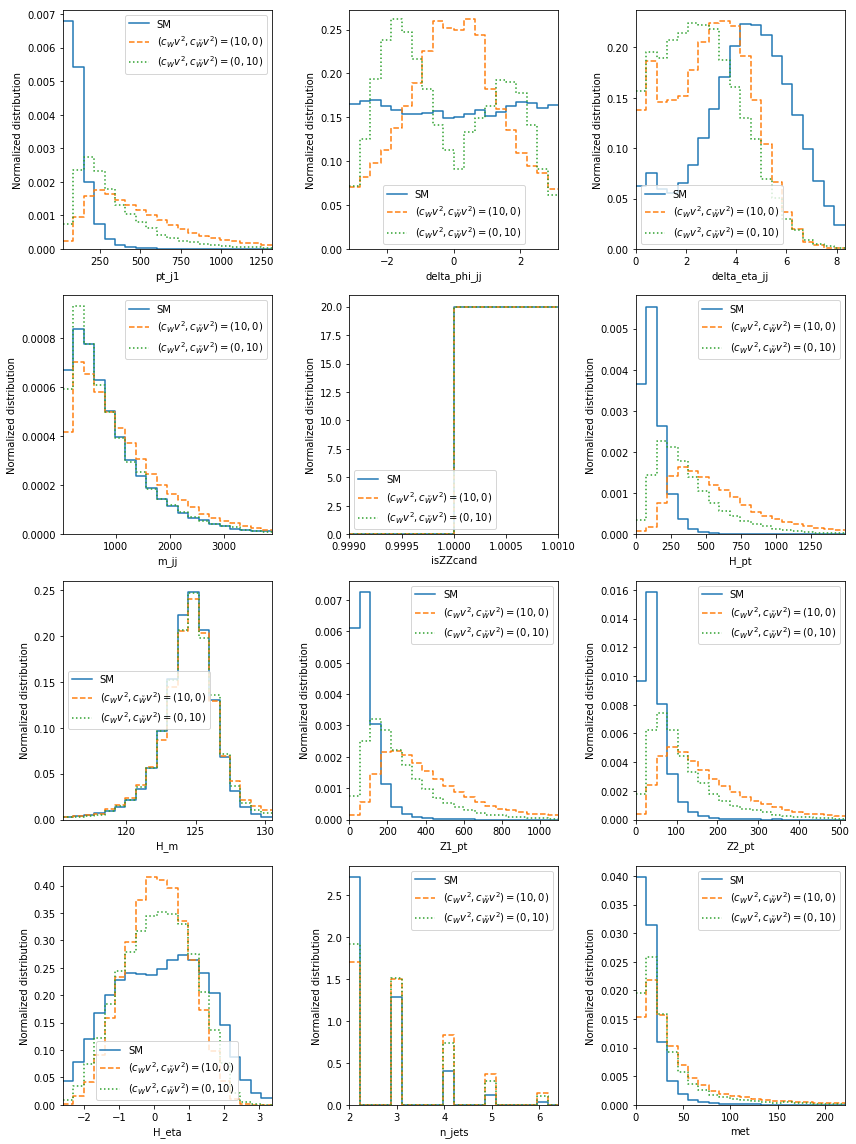

In [46]:
_ = plot_distributions(
    filename='/data_CMS/cms/cortinovis/ewdim6/data_ew_1M/delphes_data.h5',
    parameter_points=['sm',  np.array([10.,0.]), np.array([0.,10.])],
    #parameter_points=['neg_w',  'w'],
    line_labels=['SM',r'$(c_{W} v^2,c_{\tilde{W}} v^2)=(10,0)$', r'$(c_{W} v^2,c_{\tilde{W}} v^2)=(0,10)$'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

In [ ]:
_ = plot_distributions(
    filename='/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/delphes_data.h5',
    parameter_points=['sm',  np.array([10.,0.]), np.array([0.,10.])],
    #parameter_points=['sm',  np.array([1.,0.]), np.array([0.,1.])],
    #parameter_points=['sm'],
    line_labels=['SM',r'$(c_{W} v^2,c_{\tilde{W}} v^2)=(10,0)$', r'$(c_{W} v^2,c_{\tilde{W}} v^2)=(0,10)$'],
    #line_labels=['SM'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

11:54 madminer.analysis.da INFO    Loading data from /data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/delphes_data.h5
11:54 madminer.analysis.da INFO    Found 2 parameters
11:54 madminer.analysis.da DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
11:54 madminer.analysis.da DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
11:54 madminer.analysis.da INFO    Did not find nuisance parameters
11:54 madminer.analysis.da INFO    Found 6 benchmarks, of which 6 physical
11:54 madminer.analysis.da DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
11:54 madminer.analysis.da DEBUG      w: CWL2 = 15.20, CPWL2 = 0.10
11:54 madminer.analysis.da DEBUG      neg_w: CWL2 = -1.54e+01, CPWL2 = 0.20
11:54 madminer.analysis.da DEBUG      ww: CWL2 = 0.30, CPWL2 = 15.10
11:54 madminer.analysis.da DEBUG      neg_ww: CWL2 = 0.40, CPWL2 = -1.53e+01
11:54 madminer.analysis.da DEBUG      morphing_basis_vector_5: CWL2 = 14.51, CPWL2 = -2.00e+0

In [41]:
_ = plot_distributions(
    filename='dim6/data_1M/delphes_data.h5',
    parameter_points=['sm',  np.array([10.,0.]), np.array([0.,10.])],
    #parameter_points=['neg_w',  'w'],
    line_labels=['SM', 'BSM1', 'BSM2'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

00:17 madminer.analysis.da INFO    Loading data from dim6/data_1M/delphes_data.h5


OSError: Unable to open file (unable to open file: name = 'dim6/data_1M/delphes_data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

01:12 madminer.analysis.da INFO    Loading data from ewdim6/data_ew_wb/delphes_data.h5
01:12 madminer.analysis.da INFO    Found 2 parameters
01:12 madminer.analysis.da DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
01:12 madminer.analysis.da DEBUG      CBL2 (LHA: dim6 3, maximal power in squared ME: (2,), range: (-20.0, 20.0))
01:12 madminer.analysis.da INFO    Did not find nuisance parameters
01:12 madminer.analysis.da INFO    Found 6 benchmarks, of which 6 physical
01:12 madminer.analysis.da DEBUG      sm: CWL2 = 0.00e+00, CBL2 = 0.00e+00
01:12 madminer.analysis.da DEBUG      w: CWL2 = 15.20, CBL2 = 0.10
01:12 madminer.analysis.da DEBUG      neg_w: CWL2 = -1.54e+01, CBL2 = 0.20
01:12 madminer.analysis.da DEBUG      ww: CWL2 = 0.30, CBL2 = 15.10
01:12 madminer.analysis.da DEBUG      neg_ww: CWL2 = 0.40, CBL2 = -1.53e+01
01:12 madminer.analysis.da DEBUG      morphing_basis_vector_5: CWL2 = -1.79e+01, CBL2 = -1.33e+01
01:12 madminer.analysis.da IN

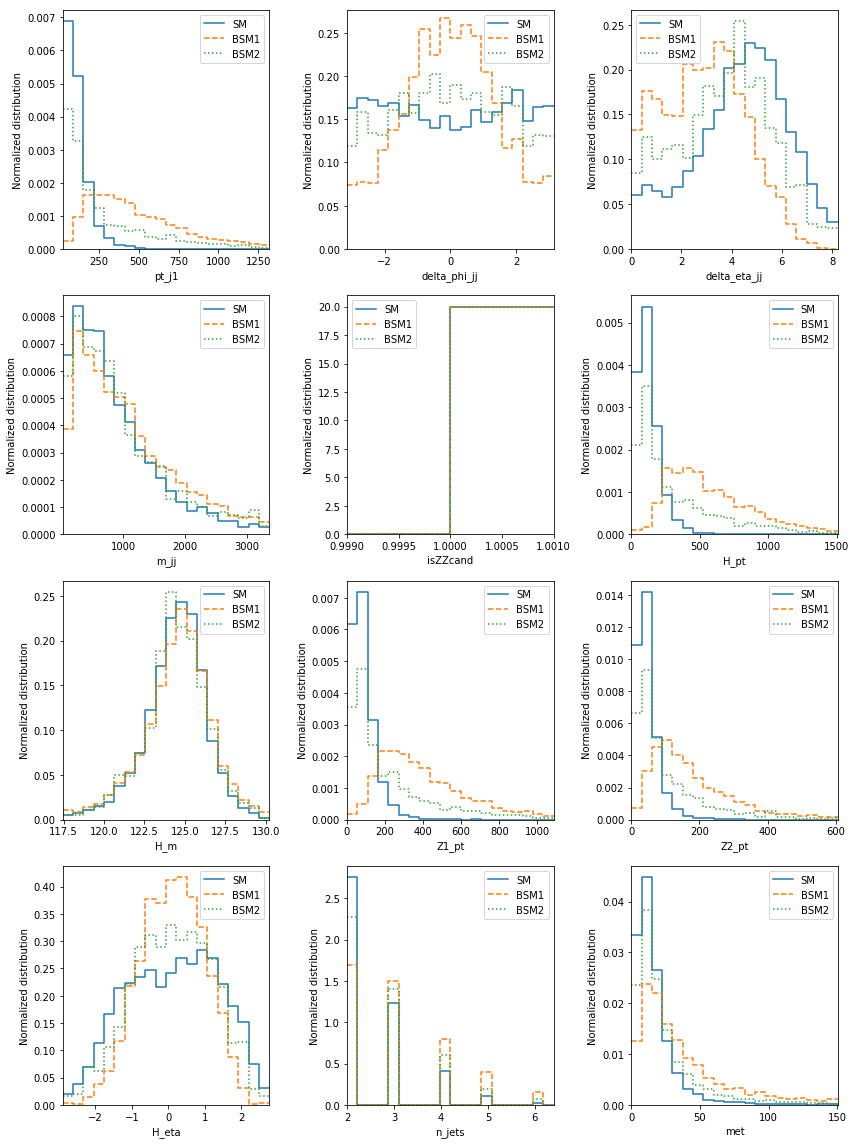

In [456]:
_ = plot_distributions(
    filename='/data_CMS/cms/cortinovis/ewdim6/data_ew_wb/delphes_data.h5',
    parameter_points=['sm',  np.array([10.,0.]), np.array([0.,10.])],
    #parameter_points=['neg_w',  'w'],
    line_labels=['SM', 'BSM1', 'BSM2'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

10:05 madminer.analysis.da INFO    Loading data from ewdim6/data_ew_02_100k/delphes_data.h5
10:05 madminer.analysis.da INFO    Found 2 parameters
10:05 madminer.analysis.da DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
10:05 madminer.analysis.da DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
10:05 madminer.analysis.da INFO    Did not find nuisance parameters
10:05 madminer.analysis.da INFO    Found 6 benchmarks, of which 6 physical
10:05 madminer.analysis.da DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:05 madminer.analysis.da DEBUG      w: CWL2 = 15.20, CPWL2 = 0.10
10:05 madminer.analysis.da DEBUG      neg_w: CWL2 = -1.54e+01, CPWL2 = 0.20
10:05 madminer.analysis.da DEBUG      ww: CWL2 = 0.30, CPWL2 = 15.10
10:05 madminer.analysis.da DEBUG      neg_ww: CWL2 = 0.40, CPWL2 = -1.53e+01
10:05 madminer.analysis.da DEBUG      morphing_basis_vector_5: CWL2 = 14.51, CPWL2 = -2.00e+01
10:05 madminer.analys

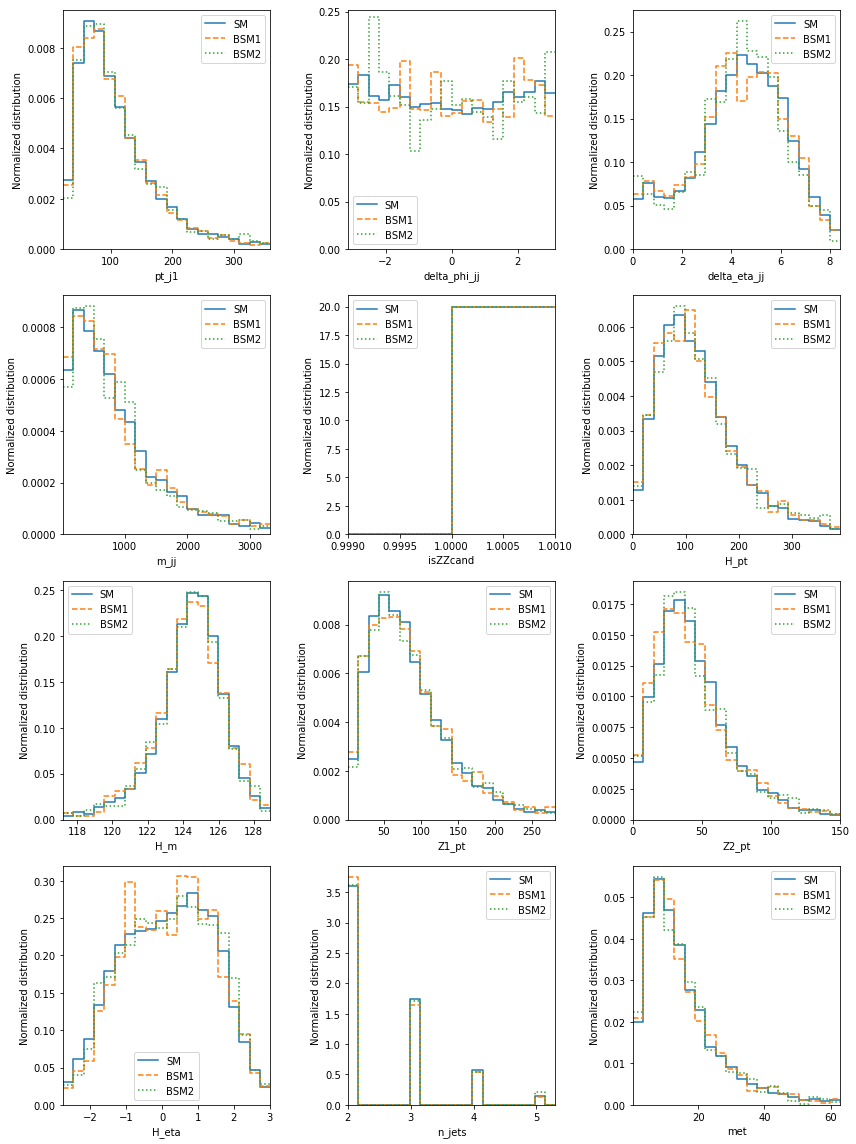

In [461]:
_ = plot_distributions(
    filename='ewdim6/data_ew_02_100k/delphes_data.h5',
    parameter_points=['sm',  np.array([10.,0.]), np.array([0.,10.])],
    line_labels=['SM', 'BSM1', 'BSM2'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

20:02 madminer.analysis.da INFO    Loading data from data_hel_w_b/delphes_data.h5
20:02 madminer.analysis.da INFO    Found 2 parameters
20:02 madminer.analysis.da DEBUG      cWW (LHA: newcoup 7, maximal power in squared ME: (2,), range: (-10.0, 10.0))
20:02 madminer.analysis.da DEBUG      cB (LHA: newcoup 8, maximal power in squared ME: (2,), range: (-10.0, 10.0))
20:02 madminer.analysis.da INFO    Did not find nuisance parameters
20:02 madminer.analysis.da INFO    Found 6 benchmarks, of which 6 physical
20:02 madminer.analysis.da DEBUG      sm: cWW = 0.00e+00, cB = 0.00e+00
20:02 madminer.analysis.da DEBUG      w: cWW = 6.00, cB = 0.10
20:02 madminer.analysis.da DEBUG      neg_w: cWW = -6.80e+00, cB = 0.20
20:02 madminer.analysis.da DEBUG      ww: cWW = 0.40, cB = 6.60
20:02 madminer.analysis.da DEBUG      neg_ww: cWW = 0.30, cB = -6.70e+00
20:02 madminer.analysis.da DEBUG      morphing_basis_vector_5: cWW = -9.38e+00, cB = 6.84
20:02 madminer.analysis.da INFO    Found 19 observables


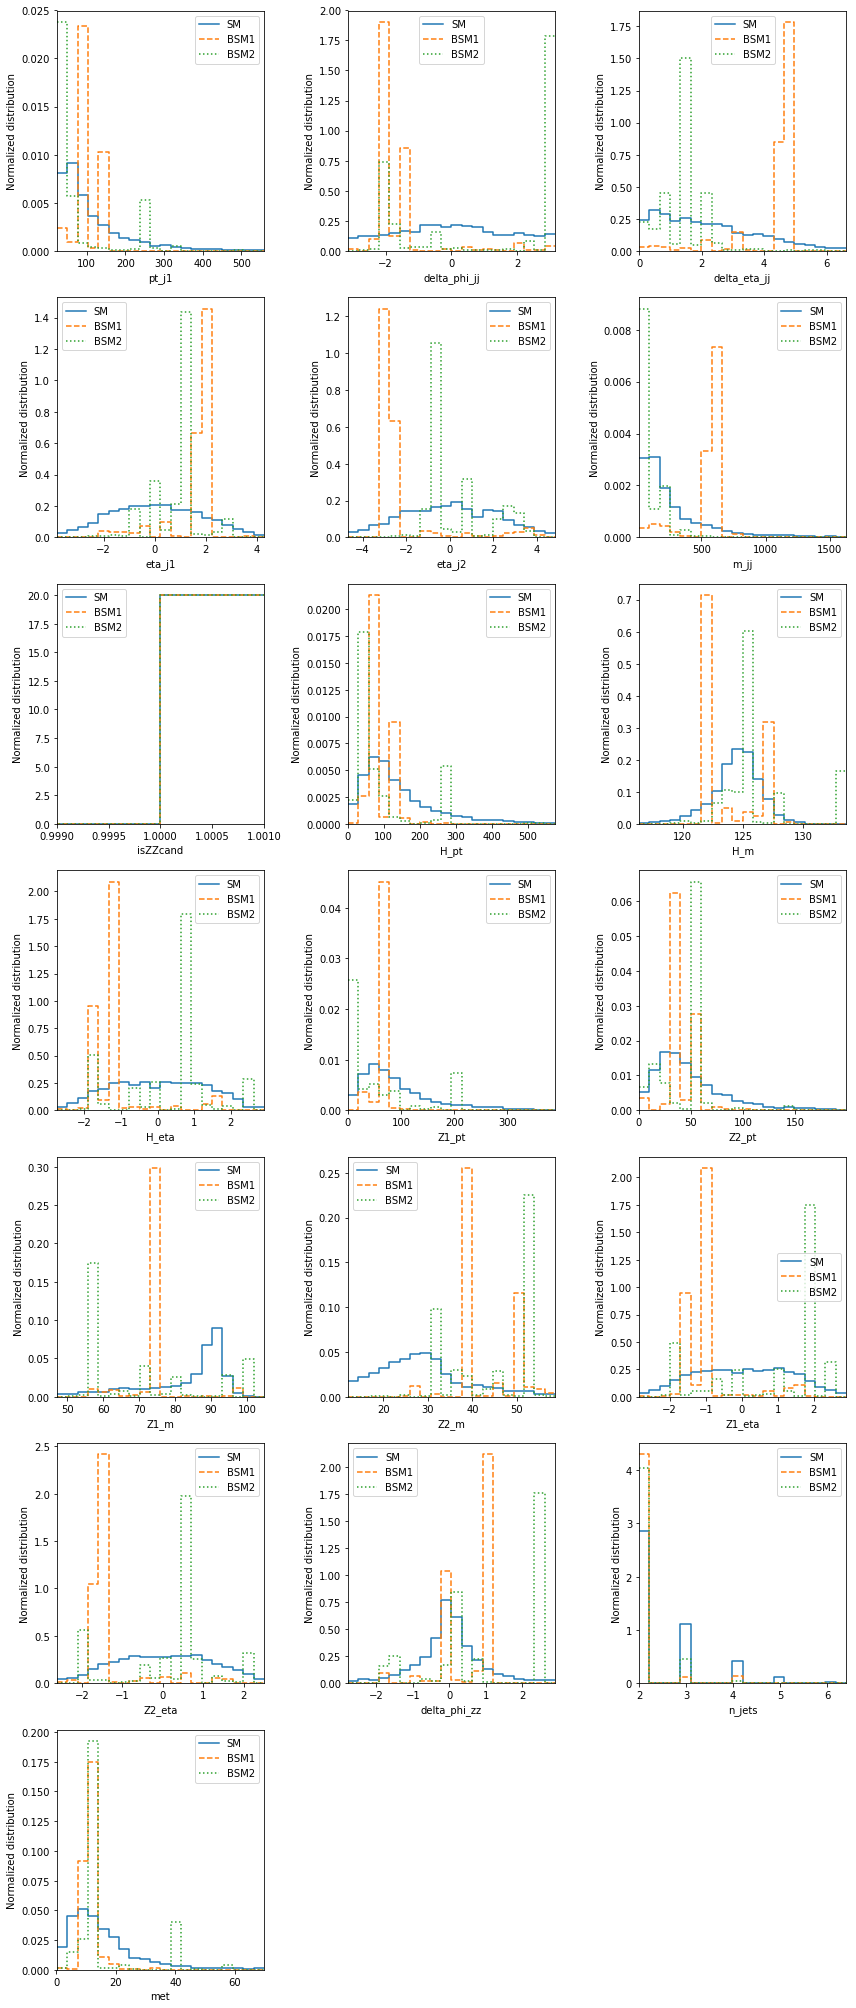

In [16]:
_ = plot_distributions(
    filename='data_hel_w_b/delphes_data.h5',
    parameter_points=['sm',  np.array([10.,0.]), np.array([0.,10.])],
    line_labels=['SM', 'BSM1', 'BSM2'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

## 6. Combine and shuffle different samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

This is generally good practice even if you use just one sample, since the events might have some inherent ordering (e.g. from sampling from different hypotheses). Later when we split the events into a training and test fraction, such an ordering could cause problems.

In [453]:
combine_and_shuffle(
    ['/data_CMS/cms/cortinovis/ewdim6/data_ew_1M/delphes_data_mjj.h5'],
    '/data_CMS/cms/cortinovis/ewdim6/data_ew_1M/delphes_data_shuffled_mjj.h5'
)

19:41 madminer.sampling.co DEBUG   Combining and shuffling samples
19:41 madminer.sampling.co DEBUG   Copying setup from ewdim6/data_ew_02_100k/delphes_data.h5 to ewdim6/data_ew_02_100k/delphes_data_shuffled.h5
19:41 madminer.sampling.co DEBUG   Loading samples from file 1 / 1 at ewdim6/data_ew_02_100k/delphes_data.h5, multiplying weights with k factor 1.0
19:41 madminer.sampling.co DEBUG   Sampling benchmarks: [2 2 1 ... 4 4 3]
19:41 madminer.sampling.co DEBUG   Combined sampling benchmarks: [2 2 1 ... 4 4 3]
19:41 madminer.sampling.co DEBUG   Recalculated event numbers per benchmark: [6929 1418 1377 1306 1388    0], background: 0


In [18]:
import h5py

def get_all(name):
    print(name)

with h5py.File('data_hel/delphes_data.h5', 'r') as f:
    g_name = f.visit(get_all)
    d = f['samples/observations']
    print(len([a for a in d[:,0] if a!=0]))
    print(len(d[:,0]))
    #for item in d[:]:
        #print(item[1])

benchmarks
benchmarks/is_nuisance
benchmarks/is_reference
benchmarks/names
benchmarks/values
morphing
morphing/components
morphing/morphing_matrix
observables
observables/definitions
observables/names
parameters
parameters/lha_blocks
parameters/lha_ids
parameters/max_power
parameters/names
parameters/ranges
parameters/transforms
sample_summary
sample_summary/background_events
sample_summary/signal_events_per_benchmark
samples
samples/observations
samples/sampling_benchmarks
samples/weights


TypeError: Argument sequence too long